# Scan MERRA-2 atmospheric properties during one month
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation January 12 2017
- update January 12 2016

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One month of MERRA-2 predictions of the dataset tavg1_2d_aer_Nx_M2T1NXAER. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
# SELECT MONTH IN 2016
MONTH_NAME='11' # select october

In [11]:
# SELECT OBSERVATORY
OBS_NAME='ohp'

In [12]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/tavg1_2d_aer_Nx_M2T1NXAER"

In [13]:
path=HDFEOS_ZOO_DIR

### Here I describe the content of the input files

In [14]:
DATA_TAG=['TOTANGSTR','TOTEXTTAU','TOTSCATAU']

In [15]:
DATA_TITLE=['Total Aerosol Angstrom parameter 470-870 nm',
            'Total Aerosol Extinction AOT 550 nm',
            'Total Aerosol Scattering AOT 550 nm'
           ]

In [16]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [17]:
# The selected data field
DATA_NAME =  'tavg1_2d_aer_Nx_M2T1NXAER'   # 

In [18]:
pandas_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'.csv'

In [19]:
fits_filename='MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME +'.fits'

In [20]:
# 6 output files for figures
figfile_aer_angstr='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_aer_angstr'+'.jpg'
figfile_aer_extinct='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_aer_extinct'+'.jpg'
figfile_aer_scatter='GMAO_MERRA2_2016_'+DATA_NAME+'_'+OBS_NAME+'_'+MONTH_NAME+'_aer_scatter'+'.jpg'

### Select where in the world

In [21]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [22]:
loc

(5.71222222222, 43.9316666667, 650.0)

### 2.2) Getting the list of the files
------------------------------

In [23]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [24]:
nc4_files[:5]

['MERRA2_100.tavg1_2d_aer_Nx.19800101.nc4',
 'MERRA2_100.tavg1_2d_aer_Nx.19800102.nc4',
 'MERRA2_100.tavg1_2d_aer_Nx.19800103.nc4',
 'MERRA2_100.tavg1_2d_aer_Nx.19800104.nc4',
 'MERRA2_100.tavg1_2d_aer_Nx.19800105.nc4']

### 2.3) Select files of a given month

In [25]:
keysel_filename='^MERRA2_400.tavg1_2d_aer_Nx.2016{}.*'.format(MONTH_NAME)

In [26]:
print 'Selection key' ,keysel_filename

Selection key ^MERRA2_400.tavg1_2d_aer_Nx.201611.*


In [27]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [28]:
nc4_files2

array(['MERRA2_400.tavg1_2d_aer_Nx.20161101.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161102.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161103.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161104.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161105.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161106.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161107.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161108.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161109.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161110.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161111.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161112.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161113.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161114.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161115.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161116.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161117.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161118.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161119.nc4',
       'MERRA2_400.tavg1_2d_aer_Nx.20161120.nc4',


### 2.4) Sort files by increasing time

In [29]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [30]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [31]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]


df_tavg1_2d_aer_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print 'start_time = ', start_time
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)

            
        #clf_timeseries.append(ts)
        # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2 }, index=time_rng)
    df_tavg1_2d_aer_Nx.append(df)  
    

start_time =  ['2016-11-01 00:30:00']
start_time =  ['2016-11-02 00:30:00']
start_time =  ['2016-11-03 00:30:00']
start_time =  ['2016-11-04 00:30:00']
start_time =  ['2016-11-05 00:30:00']
start_time =  ['2016-11-06 00:30:00']
start_time =  ['2016-11-07 00:30:00']
start_time =  ['2016-11-08 00:30:00']
start_time =  ['2016-11-09 00:30:00']
start_time =  ['2016-11-10 00:30:00']
start_time =  ['2016-11-11 00:30:00']
start_time =  ['2016-11-12 00:30:00']
start_time =  ['2016-11-13 00:30:00']
start_time =  ['2016-11-14 00:30:00']
start_time =  ['2016-11-15 00:30:00']
start_time =  ['2016-11-16 00:30:00']
start_time =  ['2016-11-17 00:30:00']
start_time =  ['2016-11-18 00:30:00']
start_time =  ['2016-11-19 00:30:00']
start_time =  ['2016-11-20 00:30:00']
start_time =  ['2016-11-21 00:30:00']
start_time =  ['2016-11-22 00:30:00']
start_time =  ['2016-11-23 00:30:00']
start_time =  ['2016-11-24 00:30:00']
start_time =  ['2016-11-25 00:30:00']
start_time =  ['2016-11-26 00:30:00']
start_time =

### Concatenation

In [32]:
df_tavg1_2d_aer_Nx=pd.concat(df_tavg1_2d_aer_Nx)

In [33]:
df_tavg1_2d_aer_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 720 entries, 2016-11-01 00:30:00 to 2016-11-30 23:30:00
Data columns (total 3 columns):
TOTANGSTR    720 non-null float32
TOTEXTTAU    720 non-null float32
TOTSCATAU    720 non-null float32
dtypes: float32(3)
memory usage: 14.1 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [34]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_tavg1_2d_aer_Nx[DATA_TAG[index]].plot(lw=3,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in 2016/{}".format(DATA_TITLE[index],OBS_NAME,MONTH_NAME)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) Angstrom

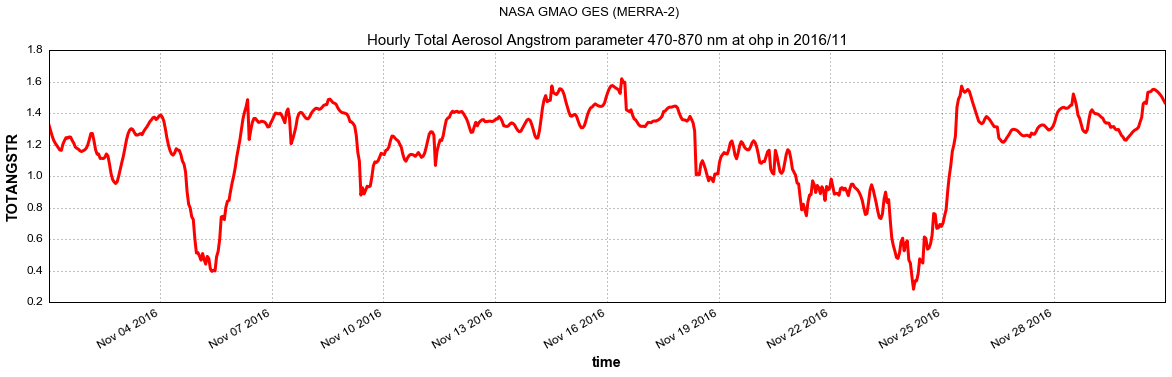

In [35]:
PlotTimeSeries(0,figfile_aer_angstr)

###  4.2)  Aerosols extinction

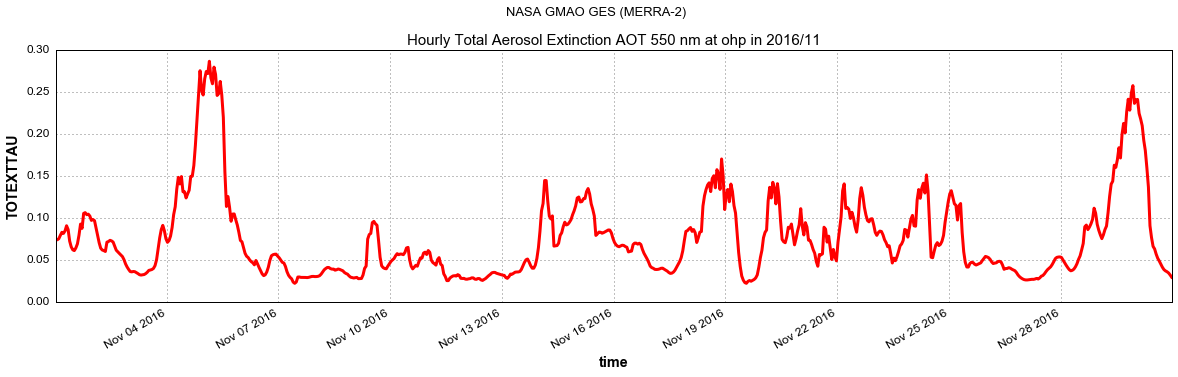

In [36]:
PlotTimeSeries(1,figfile_aer_extinct)

### 4.3) Aerosols scattering

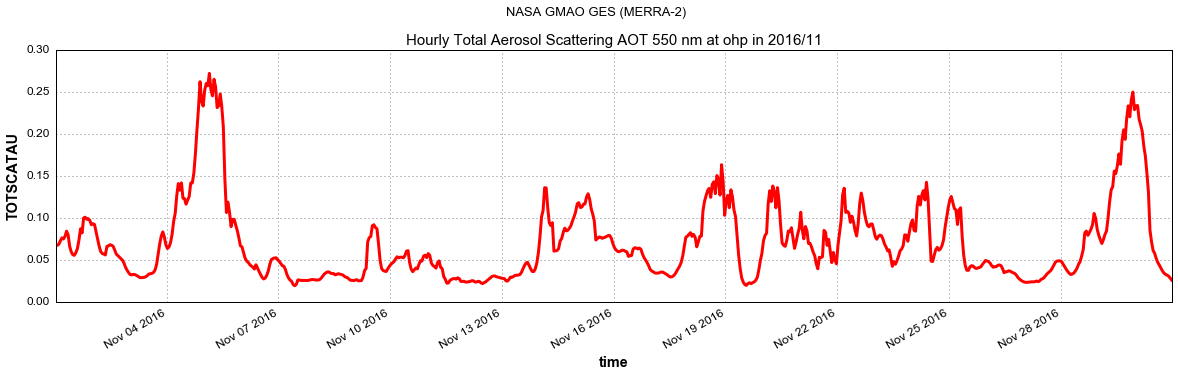

In [37]:
PlotTimeSeries(2,figfile_aer_scatter)

## 5) Output

In [38]:
df_tavg1_2d_aer_Nx.index.name='time'
df_tavg1_2d_aer_Nx.describe()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
count,720.000000,720.000000,720.000000
mean,1.193414,0.076226,0.071053
std,0.265348,0.050457,0.048790
min,0.281200,0.022252,0.019411
25%,1.086361,0.039854,0.035610
50%,1.276567,0.061999,0.057235
75%,1.369683,0.093452,0.088118
max,1.617553,0.286591,0.272215


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [39]:
dataset=df_tavg1_2d_aer_Nx

In [40]:
dataset.index.name='time'

In [41]:
dataset.describe()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
count,720.000000,720.000000,720.000000
mean,1.193414,0.076226,0.071053
std,0.265348,0.050457,0.048790
min,0.281200,0.022252,0.019411
25%,1.086361,0.039854,0.035610
50%,1.276567,0.061999,0.057235
75%,1.369683,0.093452,0.088118
max,1.617553,0.286591,0.272215


In [42]:
dataset.head()

,TOTANGSTR,TOTEXTTAU,TOTSCATAU
time,,,
2016-11-01 00:30:00,1.324808,0.074489,0.067742
2016-11-01 01:30:00,1.289908,0.074081,0.067488
2016-11-01 02:30:00,1.255869,0.075358,0.068789
2016-11-01 03:30:00,1.228245,0.079394,0.072790
2016-11-01 04:30:00,1.209285,0.082988,0.076332


In [43]:
dataset.to_csv(pandas_filename)

In [44]:
saved_dataset=pd.read_csv(pandas_filename)

In [45]:
saved_dataset.head()

,time,TOTANGSTR,TOTEXTTAU,TOTSCATAU
0,2016-11-01 00:30:00,1.324808,0.074489,0.067742
1,2016-11-01 01:30:00,1.289908,0.074081,0.067488
2,2016-11-01 02:30:00,1.255869,0.075358,0.068789
3,2016-11-01 03:30:00,1.228245,0.079394,0.072790
4,2016-11-01 04:30:00,1.209285,0.082988,0.076332


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [46]:
table = Table.from_pandas(saved_dataset)

In [47]:
table

time,TOTANGSTR,TOTEXTTAU,TOTSCATAU
str19,float64,float64,float64
2016-11-01 00:30:00,1.32480764389,0.074488684535,0.0677421838045
2016-11-01 01:30:00,1.28990828991,0.0740809887648,0.067487552762
2016-11-01 02:30:00,1.25586903095,0.0753575116396,0.0687892511487
2016-11-01 03:30:00,1.22824454308,0.0793938189745,0.0727896392345
2016-11-01 04:30:00,1.20928549767,0.0829880088568,0.0763317719102
2016-11-01 05:30:00,1.19436335564,0.0816955119371,0.0750579535961
2016-11-01 06:30:00,1.17848443985,0.0846890285611,0.0781206637621
2016-11-01 07:30:00,1.1650853157,0.0907758399844,0.0843615606427
2016-11-01 08:30:00,1.16282141209,0.086298301816,0.0800654813647


In [48]:
table.write(fits_filename,format='fits',overwrite=True)